# Notebook to train CNNs

In [1]:
# Load libraries
import matplotlib.pyplot as plt
import random
import os
import numpy as np
import tensorflow as tf
import pandas as pd
import math
from pathlib import Path
from Resnet3D_model import Resnet3DBuilder
from sklearn.metrics import classification_report, balanced_accuracy_score, f1_score, matthews_corrcoef, roc_auc_score, roc_curve, accuracy_score, recall_score
from data_utils import create_dataset, get_paths_and_labels, calculate_min_max, clean_zone_identifier_files
from plotting_utils import view_image, view_random_image, plot_loss_curves, make_confusion_matrix, view_image_data
from sklearn.utils import class_weight


2025-04-26 10:54:44.722560: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-04-26 10:54:45.242822: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# Set seeds for reproducibility
seed = 30
os.environ['PYTHONHASHSEED'] = str(seed)
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

print(f"Seeds set for reproducibility (seed={seed})")
print(f"PYTHONHASHSEED set to: {os.environ.get('PYTHONHASHSEED')}")

Seeds set for reproducibility (seed=30)
PYTHONHASHSEED set to: 30


In [3]:
# Set mixed precision policy to 'mixed_float16'
policy = tf.keras.mixed_precision.Policy('mixed_float16')
tf.keras.mixed_precision.set_global_policy(policy)
print('Mixed precision policy set to:', policy.name)

Mixed precision policy set to: mixed_float16


In [4]:
NORMALIZATION = "mni_reg" # Choose mni_reg
DATASET = "smci_pmci" # Choose dataset: "smci_pmci" or "nc_ad"
BATCH_SIZE = 4 # Choose batch size

DATA_DIR = Path("/home/diogommiranda/tese/datasets/") / NORMALIZATION / DATASET
ROI_MASK_PATH = str(Path("/home/diogommiranda/tese/masks/ROI_MASK.nii"))
ROI_MASK_PATH = None
VOLUME_SHAPE = (91, 109, 91) # Expected volume shape of the PET nifti images

# Get train paths to calculate minmax values
train_paths, train_labels, class_map = get_paths_and_labels(DATA_DIR, 'train')
train_paths = np.array(train_paths)
train_labels = np.array(train_labels)
    
# Calculate minmax values for train set
minmax_min, minmax_max = calculate_min_max(train_paths)
print(f"\nMinmax values for normalization: {minmax_min}, {minmax_max}\n")

# Create train dataset
print("\n--- Creating Train Dataset ---")
train_data = create_dataset(
    paths=train_paths,
    labels=train_labels,
    batch_size=BATCH_SIZE,
    volume_shape=VOLUME_SHAPE,
    is_training=True, 
    seed=seed,
    min_val=minmax_min, 
    max_val=minmax_max,
    mask_path=ROI_MASK_PATH
    )

# Create validation dataset
print("\n--- Creating Validation Dataset ---")
validation_paths, validation_labels, _ = get_paths_and_labels(DATA_DIR, 'validation', class_map)
validation_paths = np.array(validation_paths)
validation_labels = np.array(validation_labels)
    
val_data = create_dataset(
    paths=validation_paths,
    labels=validation_labels,
    batch_size=BATCH_SIZE,
    volume_shape=VOLUME_SHAPE,
    is_training=False, 
    seed=seed,
    min_val=minmax_min, 
    max_val=minmax_max,
    mask_path=ROI_MASK_PATH
)

# Create test dataset
print("\n--- Creating Test Dataset ---")
test_paths, test_labels, _ = get_paths_and_labels(DATA_DIR, 'test', class_map)
test_paths = np.array(test_paths)
test_labels = np.array(test_labels)

test_data = create_dataset(
    paths=test_paths,
    labels=test_labels,
    batch_size=BATCH_SIZE,
    volume_shape=VOLUME_SHAPE,
    is_training=False, 
    seed=seed,
    min_val=minmax_min, 
    max_val=minmax_max,
    mask_path=ROI_MASK_PATH
)

# Check if the datasets were successfully created
if train_data is None:
    print("ERROR: Train dataset could not be created.")
    exit()
if val_data is None:
    print("ERROR: Validation dataset could not be created.")
    exit()
if test_data is None:
    print("ERROR: Test dataset could not be created.")
    exit()

Class map: {'smci': 0, 'pmci': 1}
Scanning /home/diogommiranda/tese/datasets/mni_reg/smci_pmci/train...
Found 460 files for class 'smci'
Found 251 files for class 'pmci'
Calculating minmax across 711 files...
Calculated Min: -0.35769128799438477, Max: 2.544045925140381

Minmax values for normalization: -0.35769128799438477, 2.544045925140381


--- Creating Train Dataset ---


2025-04-26 10:54:46.878306: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:05:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-04-26 10:54:46.895771: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:05:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-04-26 10:54:46.895826: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:05:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-04-26 10:54:46.897733: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:05:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-04-26 10:54:46.897779: I external/local_xla/xla/stream_executor

Shuffling with buffer size: 711

No mask applied.


--- Creating Validation Dataset ---
Class map: {'smci': 0, 'pmci': 1}
Scanning /home/diogommiranda/tese/datasets/mni_reg/smci_pmci/validation...
Found 115 files for class 'smci'
Found 63 files for class 'pmci'

No mask applied.


--- Creating Test Dataset ---
Class map: {'smci': 0, 'pmci': 1}
Scanning /home/diogommiranda/tese/datasets/mni_reg/smci_pmci/test...
Found 143 files for class 'smci'
Found 78 files for class 'pmci'

No mask applied.



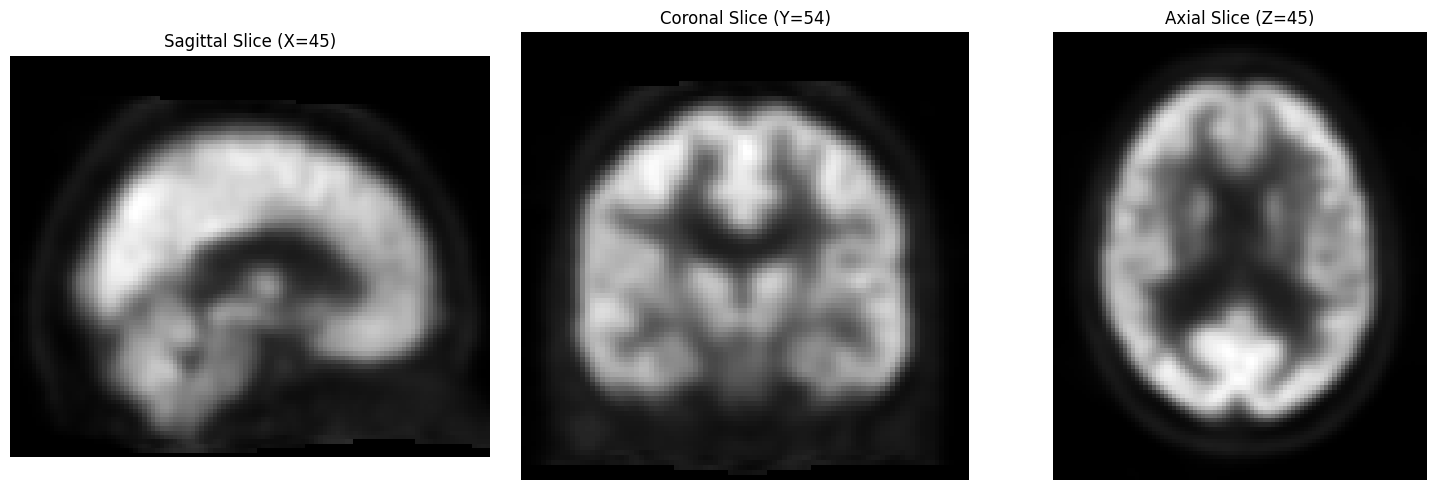

In [5]:
# verify a test sample
for data, label in test_data:
    view_image_data(data[2])
    break

In [6]:
# Calculate class weights
label_list = []

for _, label in train_data:
    label = label.numpy().flatten()
    label_list.extend(label)
    
class_weights = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(label_list),
    y=label_list
)
# Convert to a dictionary format Keras expects
class_weight_dict = dict(enumerate(class_weights))

print("Class Weights:", class_weight_dict)

Class Weights: {0: 0.7728260869565218, 1: 1.4163346613545817}


2025-04-26 10:54:50.797065: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [ ]:
# Create the ResNet18 model
model = Resnet3DBuilder.build_resnet_34((91, 109, 91, 1), 1, reg_factor=2e-4) # comparar com outro batch size para ver a min val loss: se estiver estranho voltar a experimentar com nc_ad
num_epochs = 100
#num_epochs= 200

# Cosine decay scheduler
steps_per_epoch = math.ceil(len(train_data) / BATCH_SIZE)
full_decay_steps = steps_per_epoch * num_epochs
warmup_duration = 5
decay_duration = num_epochs - warmup_duration
warmup_steps = steps_per_epoch * warmup_duration
decay_steps = steps_per_epoch * decay_duration
initial_learning_rate=5e-4 # comment if not warmup
#initial_learning_rate=1e-4 # comment if warmup
#target_learning_rate = 1e-4
alpha = 2e-3

cosine_decay = tf.keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=initial_learning_rate, decay_steps=full_decay_steps, alpha=alpha, name='CosineDecay',
    #warmup_target=target_learning_rate, warmup_steps = warmup_steps
)
#polynomial_decay=tf.keras.optimizers.schedules.PolynomialDecay(initial_learning_rate=2e-4, decay_steps=full_decay_steps, end_learning_rate=5e-7,
#    power=1.0, cycle=False, name='PolynomialDecay'
#)

auc_metric = tf.keras.metrics.AUC(name='auc')
# Compile the model
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(learning_rate=cosine_decay, clipnorm=1.0), # experimentar começar com 1e-4
              metrics=["accuracy", auc_metric])

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath='best_model.keras',
    monitor='val_loss',
    save_best_only=True,
    mode='min',
    verbose=0
)

# Create the learning rate callback
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=5, min_lr=1e-7, verbose=1)
# Create the early stopping callback
early_stopper = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True, verbose=1)

callbacks = [early_stopper, model_checkpoint]

# Train the model
history = model.fit(train_data, epochs=num_epochs, validation_data=val_data, class_weight=class_weight_dict, verbose=1, callbacks=callbacks) # Add class_weight=class_weight_dict to balance the classes

here CHANNELS last
Epoch 1/100


I0000 00:00:1745661303.849012  198765 service.cc:145] XLA service 0x7f14d4001350 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1745661303.849050  198765 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 3080, Compute Capability 8.6
2025-04-26 10:55:04.551296: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-04-26 10:55:07.312990: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907
2025-04-26 10:55:10.882819: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng10{k2=3,k13=0,k14=2,k18=0,k23=0} for conv (f16[4,256,6,7,6]{4,3,2,1,0}, u8[0]{0}) custom-call(f16[4,128,12,14,12]{4,3,2,1,0}, f16[256,128,1,1,1]{4,3,2,1,0}, f16[256]{0}, f16[4,256,6,7,6]{4,3,2,1,0}), window={size=1x1x1 stride=2x2x2}, dim_labels=bf012_oi012->bf012, custom_call_target="__cu

176/178 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.7279 - auc: 0.7394 - loss: 3.5457

2025-04-26 10:55:40.608771: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 9.07GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
I0000 00:00:1745661354.317024  198764 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_369__5', 12 bytes spill stores, 24 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_359__8', 2424 bytes spill stores, 2376 bytes spill loads
ptxas warning : Registers are spilled to local memory in function '__cuda_sm70_shflsync_down', 8 bytes spill stores, 8 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_341__7', 1828 bytes spill stores, 1680 bytes spill loads
ptxas warning : Registers are spilled to local memory in function

178/178 ━━━━━━━━━━━━━━━━━━━━ 80s 258ms/step - accuracy: 0.7282 - auc: 0.7402 - loss: 3.5406 - val_accuracy: 0.3539 - val_auc: 0.8635 - val_loss: 3.0985
Epoch 2/100
178/178 ━━━━━━━━━━━━━━━━━━━━ 17s 93ms/step - accuracy: 0.8258 - auc: 0.8603 - loss: 2.6178 - val_accuracy: 0.4270 - val_auc: 0.7124 - val_loss: 2.5813
Epoch 3/100
178/178 ━━━━━━━━━━━━━━━━━━━━ 16s 88ms/step - accuracy: 0.8137 - auc: 0.8682 - loss: 2.2018 - val_accuracy: 0.7978 - val_auc: 0.9108 - val_loss: 2.0935
Epoch 4/100
178/178 ━━━━━━━━━━━━━━━━━━━━ 21s 118ms/step - accuracy: 0.8346 - auc: 0.8820 - loss: 1.9501 - val_accuracy: 0.7865 - val_auc: 0.8644 - val_loss: 1.9131
Epoch 5/100
178/178 ━━━━━━━━━━━━━━━━━━━━ 19s 105ms/step - accuracy: 0.8836 - auc: 0.9388 - loss: 1.7561 - val_accuracy: 0.8315 - val_auc: 0.8844 - val_loss: 1.7478
Epoch 6/100
178/178 ━━━━━━━━━━━━━━━━━━━━ 18s 98ms/step - accuracy: 0.8732 - auc: 0.9327 - loss: 1.6377 - val_accuracy: 0.7753 - val_auc: 0.8817 - val_loss: 1.6491
Epoch 7/100
178/178 ━━━━━━━━━━━

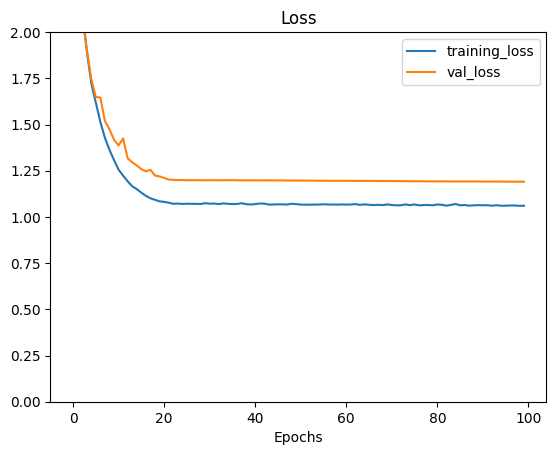

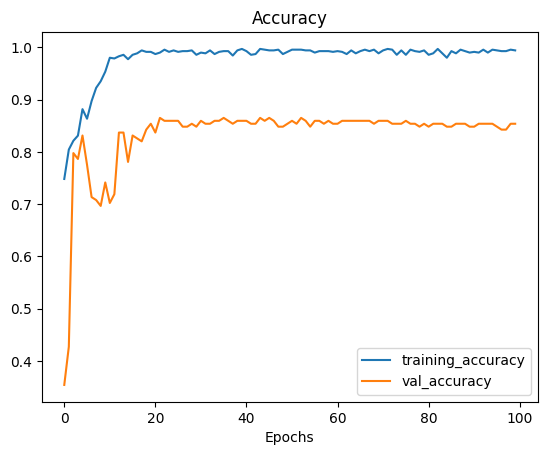

In [8]:
# Plot loss and accuracy curves
plot_loss_curves(history)

In [9]:
# Evaluate the model on the test set
result = model.evaluate(test_data, return_dict=True)
print(f"[{result['loss']}, {result['accuracy']}]")

56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 79ms/step - accuracy: 0.7925 - auc: 0.3187 - loss: 1.3311
[1.235913634300232, 0.7511312365531921]


In [10]:
# Predict on the test set
y_pred = model.predict(test_data).flatten()

# --- Print evaluation metrics ---
y_true = []
test_samples = []
for sample, label in test_data.as_numpy_iterator():
    test_samples.append(sample)
    y_true.append(label)
y_true = np.concatenate(y_true)


test_samples = np.concatenate(test_samples, axis=0)
y_true_int = y_true.astype(int)
y_pred_int = y_pred.round().astype(int)

accuracy = accuracy_score(y_true_int, y_pred_int)
sensitivity = recall_score(y_true_int, y_pred_int, pos_label=1)
specificity = recall_score(y_true_int, y_pred_int, pos_label=0)
bacc = balanced_accuracy_score(y_true_int, y_pred_int)
f1 = f1_score(y_true_int, y_pred_int, average='weighted')
mcc = matthews_corrcoef(y_true_int, y_pred_int)

auc_score = result.get('auc')

print(f"\n--- Evaluation Metrics on Test Set ---")
print(f"Accuracy:    {accuracy:.4f}")
print(f"Sensitivity: {sensitivity:.4f}")
print(f"Specificity: {specificity:.4f} ")
print(f"Balanced Accuracy (BACC): {bacc:.4f}")
print(f"F1 Score (Weighted):      {f1:.4f}") 
print(f"Matthews Corr Coef (MCC): {mcc:.4f}")
print(f"Area Under the Curve (AUC): {auc_score:.4f}\n")


14/14 ━━━━━━━━━━━━━━━━━━━━ 7s 251ms/step


2025-04-25 19:24:55.928660: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence



--- Evaluation Metrics on Test Set ---
Accuracy:    0.7964
Sensitivity: 0.5897
Specificity: 0.9091 
Balanced Accuracy (BACC): 0.7494
F1 Score (Weighted):      0.7886
Matthews Corr Coef (MCC): 0.5389
Area Under the Curve (AUC): 0.8157



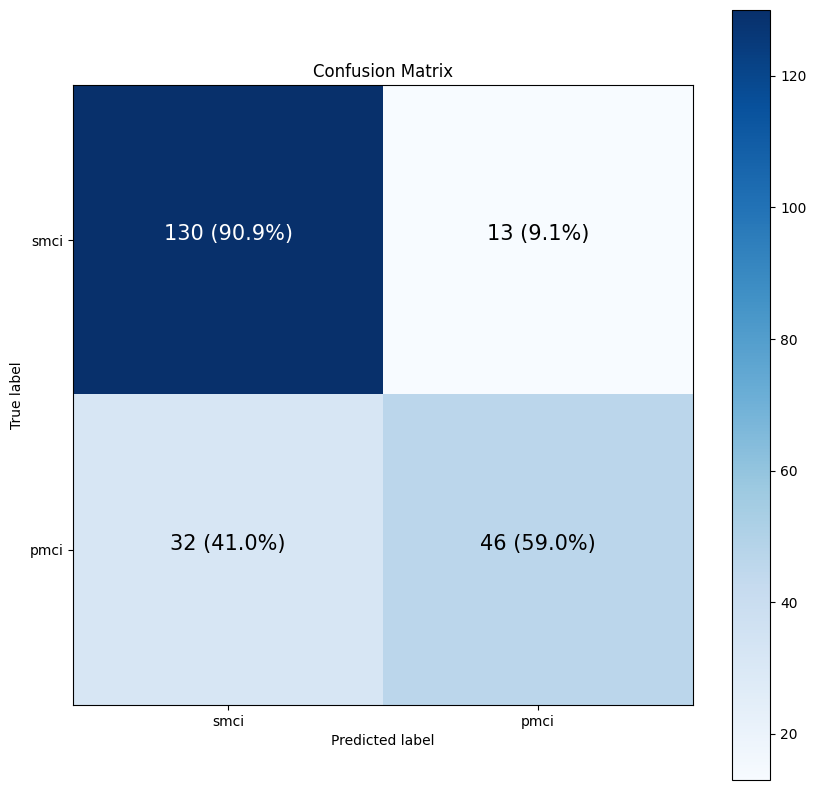

In [11]:
# --- Plot confusion matrix ---
class0, class1 = DATASET.split("_")
target_names = [class0, class1]

make_confusion_matrix(y_true=y_true,
                      y_pred=y_pred.round(),
                      classes=target_names,
                      figsize=(10, 10),
                      text_size=15)

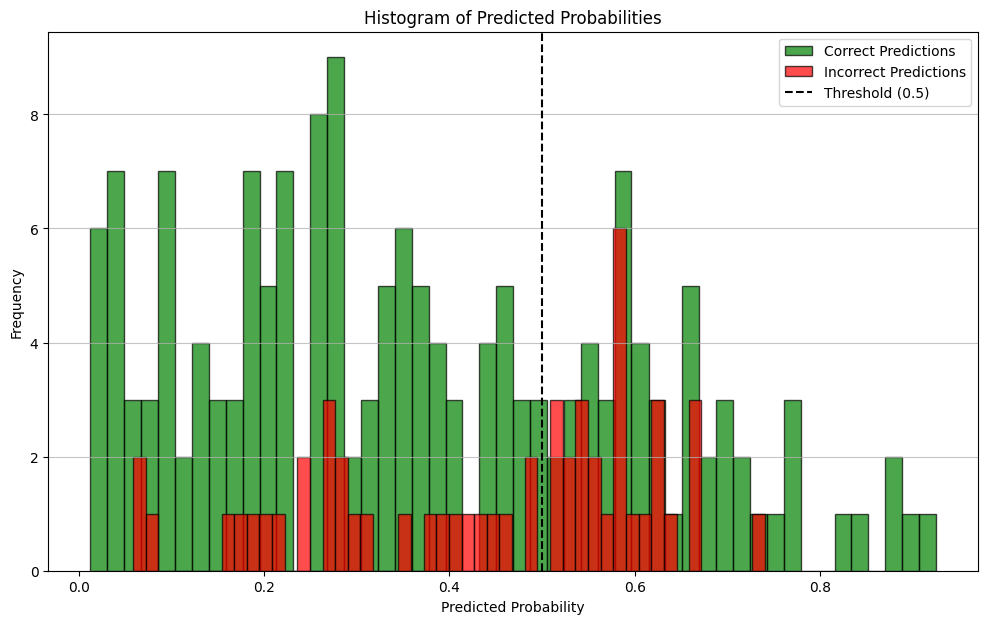

In [ ]:
# --- Plot histogram of predicted probabilities ---
correct_mask = ( y_pred_int == y_true_int)
incorrect_mask = ( y_pred_int != y_true_int)

correct_preds_probs = y_pred[correct_mask]
incorrect_preds_probs = y_pred[incorrect_mask]

plt.figure(figsize=(12, 7))
plt.hist(correct_preds_probs, bins=50, alpha=0.7, color='green', edgecolor='black', label='Correct Predictions')
plt.hist(incorrect_preds_probs, bins=50, alpha=0.7, color='red', edgecolor='black', label='Incorrect Predictions')
plt.title('Histogram of Predicted Probabilities')
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.legend()
plt.grid(axis='y', alpha=0.75)
plt.axvline(x=0.5, color='black', linestyle='--', label='Threshold (0.5)')
plt.legend()
plt.show()

In [12]:
# --- Select and view samples with predicted probabilities under/above the threshold ---
threshold = 0.1

low_prob_mask = (y_pred < threshold)
samples_low_prob = test_samples[low_prob_mask]
preds_low_prob = y_pred[low_prob_mask]
print(f"Number of samples with low probability predictions: {len(samples_low_prob)}")

high_prob_mask = (y_pred > 1 - threshold)
samples_high_prob = test_samples[high_prob_mask]
preds_high_prob = y_pred[high_prob_mask]
print(f"Number of samples with high probability predictions: {len(samples_high_prob)}")

incorrect_low_mask = incorrect_mask & low_prob_mask
samples_incorrect_low = test_samples[incorrect_low_mask]
preds_incorrect_low = y_pred[incorrect_low_mask]
print(f"Number of samples with low probability predictions that are incorrect: {len(samples_incorrect_low)}")

incorrect_high_mask = incorrect_mask & high_prob_mask
samples_incorrect_high = test_samples[incorrect_high_mask]
preds_incorrect_high = y_pred[incorrect_high_mask]
print(f"Number of samples with high probability predictions that are incorrect: {len(samples_incorrect_high)}")


Number of samples with low probability predictions: 116
Number of samples with high probability predictions: 76
Number of samples with low probability predictions that are incorrect: 6
Number of samples with high probability predictions that are incorrect: 1


In [ ]:
#view_image_data(samples_incorrect_low[5])

#### Save the model

In [ ]:
# Save the model
#model.save("/home/diogommiranda/tese/outputs/smci_pmci/resnet18/modelo1/model.keras")

## TO DO: 
- Repetir para Resnet34 e Resnet50
- Ajustar os parametros de L2 regularization
- Experimentar á parte com cross-validation se não tiver confiança nas losses
- Quando tiver confiança nas losses: Fine-tuning nc_ad para smci_pmci
- Depois da reunião: Verificar se os resultados sao melhores/iguais com as masks (á partida não é preciso fazer vários testes, só a verificação: experimentar só com um modelo)
- ver se tenho acesso aos papers que falavam sobre as ROI de PET